In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import csv
import os, sys, getopt
import csv
import pandas as pd
import seaborn as sns

In [2]:
def readfile(tfile_path, c, t):
    # readfile, see if there exists and quality above cutoff and less than time
    # t: time
    # c: cutoff
    csv_f = None
    with open(tfile_path, 'r') as f:
        csv_f = csv.reader(f)
        for time, quality in csv_f:
            if int(quality) <= c and float(time) <= t:
                return True
    return False

In [3]:
def get_data(algo, dataset):
    record_time, record_nV = {}, {}
    record_time_detail = {}
    combined = []
    t = None
    for fn in glob.glob('./{}_output/{}*.trace'.format(algo, dataset)):
        sub_detail = {}
        with open(fn, 'r') as f:
            fin = f.readlines()
        line = fin[-1]
        name = fn.split('/')[-1].split('_')[0]
        try:
            if algo == 'approx':
                time, nV = line.split()
            else:
                time, nV = line.split()[0].split(',')
        except:
            print(fn)
            continue

            time, nV = float(time), float(nV)

        # add number vertices and time respectively
        record_time[name] = [*record_time.get(name, []), float(time)]
        record_nV[name] = [*record_nV.get(name, []), float(nV)]

    return record_time, record_nV

In [4]:
opt_cutoff = {'karate':14, 'football':94, 'jazz':158, 'email':594, 'delaunay_n10':703,'netscience':899, \
              'power':2203,'as-22july06':3303,'hep-th':3926,'star2':4542,'star':6902}

In [5]:
def qrtd(record_time, record_nV, algo="GA", dataset="power", percents=[0.05,.1,.2,.5,1], maxtime=None, mintime=0, log=True):
    # max time from runs
    if maxtime is None:
        maxtime = np.max(record_time[dataset])
    interval = maxtime/200.0
    optimal = opt_cutoff[dataset]
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    x = np.arange(mintime, maxtime+interval,interval)
    for p in percents:
        c = optimal + (optimal * p/100.0)
        y = []
        for xval in x:
            num_runs = 0
            num_solutions = 0
            # find percent of runs with solution > cutoff at this time
            for tfile in glob.glob('./{}_output/{}*.trace'.format(algo, dataset)):
                result = readfile(tfile, c, xval)
                num_runs += 1
                if result:
                    num_solutions += 1
                    
            yvalue = float(num_solutions)/float(num_runs)
            y.append(yvalue)
        # plot
        if log:
            ax.semilogx(x,y,label=str(p)+"%")
        else:
            ax.plot(x,y,label=str(p)+"%")

    # making plot look pretty
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('P(solve)')
    ax.set_title(f"{algo}: Qualified RTD ({dataset})")
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
    lgd = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1,0.5), title="Solution Quality")

In [6]:
def sqd(algo, dataset, maxquality=0.005, times=[10, 25, 50, 75, 100], min_bound=0):
    # go from zero to this maximum quality, 200 intervals
    interval = maxquality/200.0
    fig = plt.figure(figsize= (10,5))
    ax = fig.add_subplot(111)
    x = np.arange(min_bound,maxquality+interval,interval)
    optimal = opt_cutoff[dataset]
    # max quality is a decimal value, compute percents for plotting
    x_percents = [v*100.0 for v in x]
    for t in times:
        y = []
        for xval in x:
            c = (xval + 1) * optimal
            num_runs = 0
            num_solutions = 0
            for tfile in glob.glob('./{}_output/{}*.trace'.format(algo, dataset)):
                result = readfile(tfile, c, t)
                num_runs += 1
                if result:
                    num_solutions += 1

            y.append(num_solutions/float(num_runs))
        # plot with percents
        ax.plot(x_percents,y,label=str(t)+"s")

    # making plot look pretty
    ax.set_xlabel('Relative Solution Quality (%)')
    ax.set_ylabel('P(solve)')
    ax.set_title(f"{algo}: Solution Quality Distributions ({dataset})")
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
    lgd = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1,0.5), title="")

In [7]:
def boxplots(sa_times, ga_times, dataset="power"):
    fig1, ax1 = plt.subplots()
    ax1.set_title('Plot')
    ax1.boxplot([sa_times, ga_times])
    plt.xticks([1, 2], ['SA', 'GA'])
    plt.title(f"Local Search Running Time Box Plots ({dataset})")
    plt.ylabel('Time (s)')

## Plots - Power

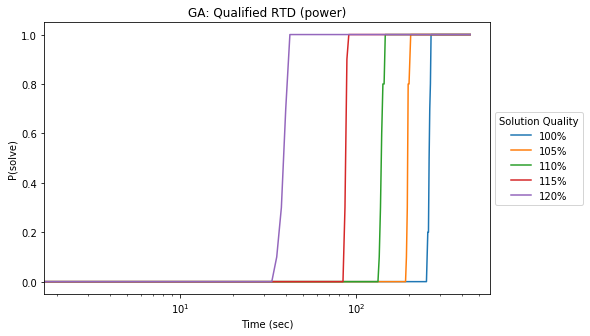

In [8]:
ga_record_time, ga_record_nV = get_data("GA", "power")
qrtd(ga_record_time, ga_record_nV, percents=[100 + 5*i for i in range(5)], algo="GA")

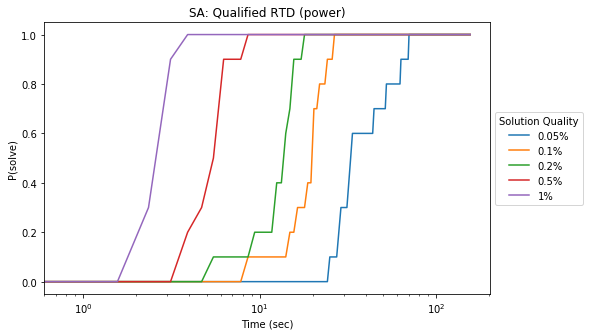

In [9]:
sa_record_time, sa_record_nV = get_data("SA", "power")
qrtd(sa_record_time, sa_record_nV, algo="SA", percents=[0.05,.1,.2,.5,1])

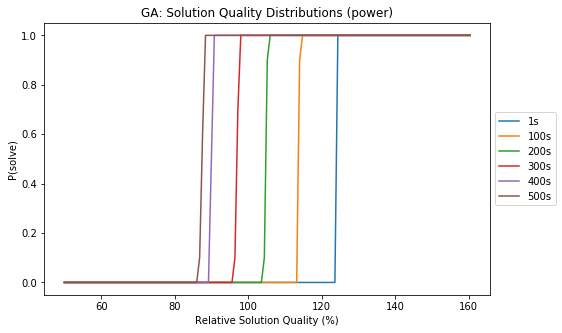

In [10]:
sqd("GA", "power", times=[1, *np.arange(100, 600, 100)], maxquality=1.6, min_bound=0.5)

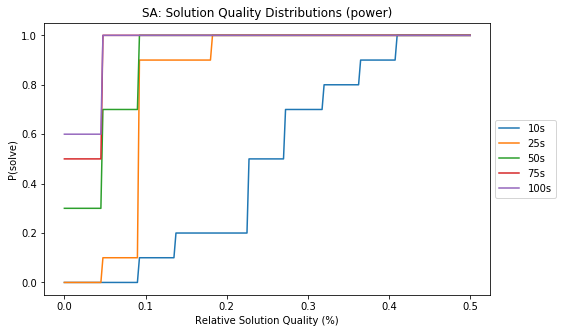

In [11]:
sqd("SA", "power", maxquality=0.005, times=[10, 25, 50, 75, 100])

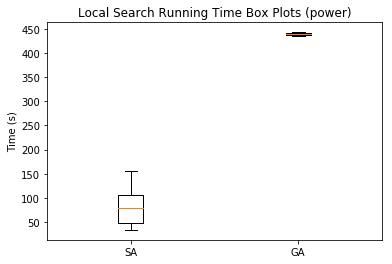

In [12]:
dataset="power"
ga_record_time, _ = get_data("GA", dataset)
sa_record_time, _ = get_data("SA", dataset)
boxplots(sa_record_time[dataset], ga_record_time[dataset], dataset=dataset)

## Plots - Star2

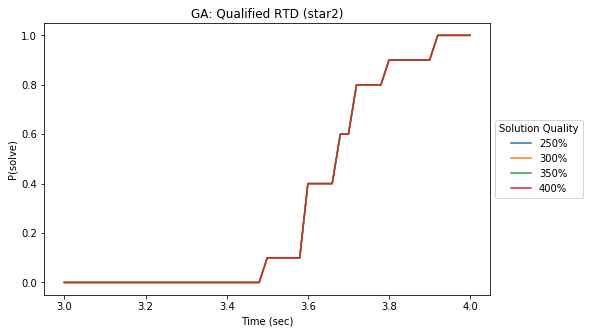

In [13]:
dataset="star2"
ga_record_time, ga_record_nV = get_data("GA", dataset)
qrtd(ga_record_time, ga_record_nV, percents=[250, 300, 350, 400], algo="GA", dataset=dataset, maxtime=4, mintime=3, log=False)

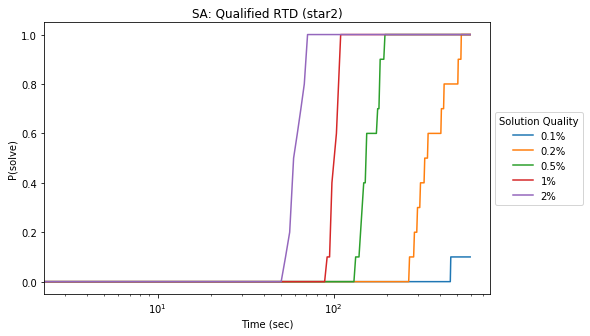

In [14]:
dataset="star2"
ga_record_time, ga_record_nV = get_data("SA", dataset)
qrtd(ga_record_time, ga_record_nV, algo="SA", dataset=dataset, percents=[.1,.2,.5,1,2])

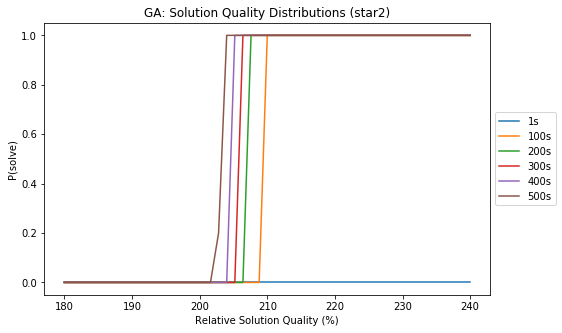

In [15]:
sqd("GA", "star2", times=[1, *np.arange(100, 600, 100)], maxquality=2.4, min_bound=1.8)

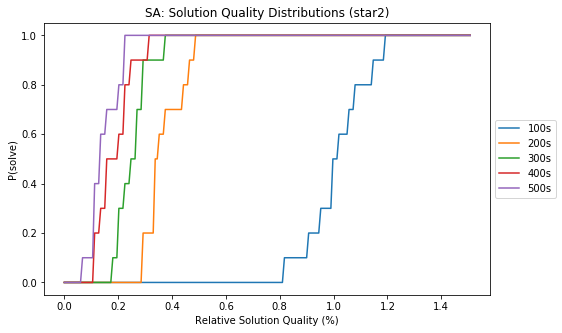

In [16]:
sqd("SA", "star2", times=[100, 200, 300, 400, 500], maxquality=0.015)

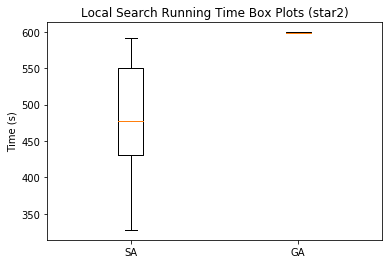

In [17]:
dataset="star2"
ga_record_time, _ = get_data("GA", dataset)
sa_record_time, _ = get_data("SA", dataset)
boxplots(sa_record_time[dataset], ga_record_time[dataset], dataset=dataset)

# Tables

In [18]:
import pandas as pd

In [19]:
opt_cutoff = {'karate':14, 'football':94, 'jazz':158, 'email':594, 'delaunay':703,'netscience':899, \
              'power':2203,'as-22july06':3303,'hep-th':3926,'star2':4542,'star':6902, 'dummy1':2, 'dummy2':3}

In [20]:
algo = "SA"
table = pd.DataFrame(columns=["dataset", "mean time (s)", "std time", "mean nV", "std nV", "err", "Opt nV"])
for i, dataset in enumerate(opt_cutoff.keys()):
    record_time, record_nV = get_data(algo, dataset)
    opt_nv = opt_cutoff[dataset]
    err = (np.mean(record_nV[dataset]) - opt_nv)/opt_nv    
    table.loc[i] = [dataset, np.mean(record_time[dataset]), np.std(record_time[dataset]), np.mean(record_nV[dataset]), np.std(record_nV[dataset]), err, opt_nv]
table

,dataset,mean time (s),std time,mean nV,std nV,err,Opt nV
0,karate,0.000588,0.000008,14.0,0.000000,0.000000,14
1,football,0.023672,0.020169,94.0,0.000000,0.000000,94
2,jazz,0.060323,0.027542,158.0,0.000000,0.000000,158
3,email,4.105720,2.545893,594.0,0.000000,0.000000,594
4,delaunay,75.335668,55.165849,703.4,0.489898,0.000569,703
5,netscience,0.049218,0.000268,899.0,0.000000,0.000000,899
6,power,85.026874,40.980768,2203.0,0.000000,0.000000,2203
7,as-22july06,38.619063,13.192088,3303.0,0.000000,0.000000,3303
8,hep-th,89.589120,143.510165,3926.0,0.000000,0.000000,3926
9,star2,476.713831,81.301102,4547.8,1.661325,0.001277,4542


In [21]:
algo = "GA"
table = pd.DataFrame(columns=["dataset", "mean time (s)", "std time", "mean nV", "std nV", "err", "Opt nV"])
for i, dataset in enumerate(opt_cutoff.keys()):
    record_time, record_nV = get_data(algo, dataset)
    opt_nv = opt_cutoff[dataset]
    err = (np.mean(record_nV[dataset]) - opt_nv)/opt_nv    
    table.loc[i] = [dataset, np.mean(record_time[dataset]), np.std(record_time[dataset]), np.mean(record_nV[dataset]), np.std(record_nV[dataset]), err, opt_nv]
table

,dataset,mean time (s),std time,mean nV,std nV,err,Opt nV
0,karate,5.602412,0.043596,14.0,0.000000,0.000000,14
1,football,13.627329,0.115419,97.1,0.943398,0.032979,94
2,jazz,25.024943,0.213199,164.1,1.445683,0.038608,158
3,email,111.720097,0.560437,750.9,8.300000,0.264141,594
4,delaunay,97.444624,0.623481,774.4,4.317407,0.101565,703
5,netscience,134.430244,0.668064,1013.1,3.753665,0.126919,899
6,power,438.900043,2.612832,4129.2,11.061645,0.874353,2203
7,as-22july06,598.975279,0.482429,22651.7,10.060318,5.857917,3303
8,hep-th,598.227039,0.055295,6853.3,10.109896,0.745619,3926
9,star2,598.835696,0.375247,13691.4,8.151074,2.014399,4542
